In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
font = {'size': 25, 'weight':'normal'}
plt.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
rng = np.random.default_rng(seed=42)
colors = [['blue',"slateblue"], ['darkgoldenrod', "goldenrod"], ['red', "indianred",], ['olivedrab', "yellowgreen"], ['plum',"pink"], ['black','dimgray'], ['orangered','coral'] ]

# Figures

## Illustration

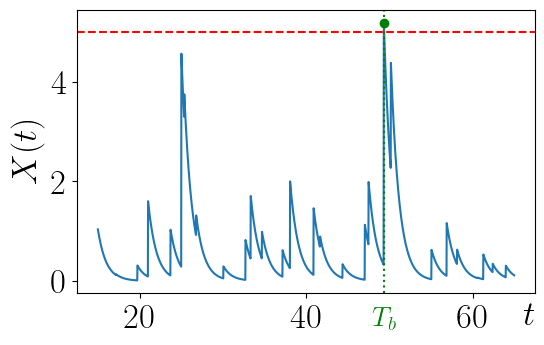

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Tmax = 50.0+15        # simulation horizon
r = 0.4            # mean arrival rate (renewal rate)
k_shape = 2.0      # shape parameter for Gamma interarrival times (k>1 = more regular)
gamma = 1.0        # kernel decay rate
lambda_mark = 1.0  # rate for exponential marks (mean=1)
threshold = 5.0

# Simulate renewal arrivals
interarrivals = np.random.gamma(shape=k_shape, scale=1/(r*k_shape), size=10000)
arrivals = np.cumsum(interarrivals)
arrivals = arrivals[arrivals < Tmax]

# Marks
marks = np.random.exponential(scale=1/lambda_mark, size=len(arrivals))

# Discretize time for plotting
t = np.linspace(15, Tmax, 2000)
X = np.zeros_like(t)

# Build shot noise: sum of exponential decays
for ti, Ai in zip(arrivals, marks):
    X += Ai * np.exp(-gamma * np.maximum(0, t - ti)) * (t >= ti)

# Find first passage time
above = np.where(X >= threshold)[0]
if len(above) > 0:
    idx_fp = above[0]
    t_fp = t[idx_fp]
    x_fp = X[idx_fp]
else:
    t_fp, x_fp = None, None

# Plot
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(t, X, label="Shot noise process")
plt.axhline(threshold, color="r", ls="--", label="Threshold")
if t_fp is not None:
    plt.axvline(t_fp, color="g", ls=":", label=f"First passage: t={t_fp:.2f}")
    plt.plot(t_fp, x_fp, "go")

ax.set_xlabel("$t$",labelpad=-25,loc='right')
ax.set_ylabel("$X(t)$",labelpad=5)
plt.text(t_fp, -0.5, "$T_b$", ha="center", va="top", fontsize=20, color="g")
# plt.title("Renewal Shot Noise with Threshold Crossing")
# plt.legend()
plt.tight_layout()

plt.savefig("Figures/illus.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [72]:
X[X>0]

array([1.26632066, 1.23503965, 1.20453135, ..., 0.04916401, 0.04794955,
       0.04676508])

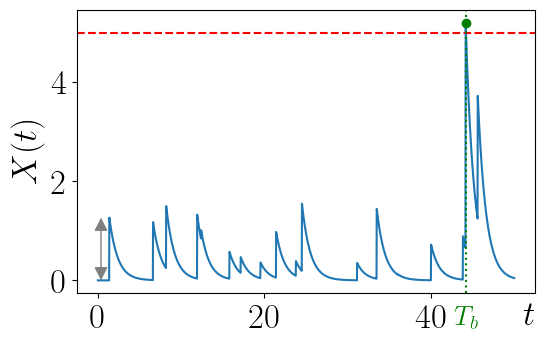

In [86]:
from matplotlib.patches import FancyArrowPatch

# Plot
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(t, X, label="Shot noise process")
plt.axhline(threshold, color="r", ls="--", label="Threshold")
if t_fp is not None:
    plt.axvline(t_fp, color="g", ls=":", label=f"First passage: t={t_fp:.2f}")
    plt.plot(t_fp, x_fp, "go")

ax.set_xlabel("$t$",labelpad=-25,loc='right')
ax.set_ylabel("$X(t)$",labelpad=5)
plt.text(t_fp, -0.5, "$T_b$", ha="center", va="top", fontsize=20, color="g")

x=t[X>0][0]-1
y=X[X>0][0]
myArrow = FancyArrowPatch(posA=(x, 0), posB=(x, y), arrowstyle='<|-|>', color='0.5',
                          mutation_scale=20, shrinkA=0, shrinkB=0)
ax.add_artist(myArrow)

plt.tight_layout()

plt.savefig("Figures/illus.pdf", dpi=600, bbox_inches='tight')
plt.show()

## Plot of MFPT

$1/\lambda_b$ is the mean amplitude, $\lambda$ is the rate of the Erlang, $k$ is the shape, $1/\gamma$ is the relaxation time

In [6]:
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from math import exp, sqrt, log

rng = np.random.default_rng(0)
k=.75

def simulate_mfpt_erlang(lam=1.0, gamma=0.5, lambda_b=1.0, b=6.0, trials=20000, seed=0):
    rng = np.random.default_rng(seed)
    T_arr = np.empty(trials, dtype=float)
    w_arr = np.empty(trials, dtype=float)

    for i in range(trials):
        X = 0.0
        t = 0.0
        logw = 0.0
        while True:
            delta = rng.gamma(k, 1/lam)
            X *= math.exp(-gamma * delta)

            B = rng.exponential(scale=1/lambda_b) 

            t += delta
            if X + B >= b:
                break
            else:
                X += B
        T_arr[i] = t
        w_arr[i] = math.exp(logw)

    # importance sampling estimator of MFPT
    mean = np.sum(w_arr * T_arr) / np.sum(w_arr)
    return {"mean_T": mean, "std_T": np.std(T_arr), "samples": T_arr, "weights": w_arr, "n": trials}

# -----------------------------
#  Theory: asymptotic MFPT and C2
# -----------------------------
def predicted_mfpt_erlang(lam=1.0, gamma=0.5, lambda_b=1.0, b=6.0):
    integers_gamma = np.arange(1,int(lambda_b * b)+1)*gamma
    r = lam/k
    return np.exp(lambda_b*b)*np.prod([1-(1/(1+mg/lam))**k for mg in integers_gamma])/r

# -----------------------------
#  Driver
# -----------------------------

# Parameters you can tweak
lam = 1.2       # Erlang scale
gamma = 6      # relaxation : better convergence for large gamma, so small relaxation time
lambda_b = 1   # inverse mean mark size
trials = 100000   # Monte Carlo trials per b
seed = 42

# Thresholds to test (larger b -> closer to asymptotic)
b_values = np.arange(2,9,step=1.0)

mfpt_values = np.zeros(b_values.size)
pred_mfpt_values = np.zeros(b_values.size)

print(b_values,mfpt_values)

print(f"Erlang(k={k}) interarrivals, exponential marks -- MFPT verification")
print(f"lam={lam}, gamma={gamma}, lambda_b={lambda_b}, trials={trials}\n")

for i,b in enumerate(b_values):
    pred = predicted_mfpt_erlang(lam=lam, gamma=gamma, lambda_b=lambda_b, b=b)
    # much better to use alpha \approx lam/pred, the probability of an impulse leading to a crossing 
    sim = simulate_mfpt_erlang(lam=lam, gamma=gamma, lambda_b=lambda_b,
                                b=b, trials=trials, seed=seed)
    
    mfpt_values[i] = sim["mean_T"]
    pred_mfpt_values[i] = pred
    ratio = sim["mean_T"] / pred
    print(f"b={b:>4.1f} |  Sim MFPT = {sim['mean_T']: .5f}   "
            f"Pred = {pred: .5f}  |  ratio sim/pred = {ratio: .3f}")




[2. 3. 4. 5. 6. 7. 8.] [0. 0. 0. 0. 0. 0. 0.]
Erlang(k=0.75) interarrivals, exponential marks -- MFPT verification
lam=1.2, gamma=6, lambda_b=1, trials=100000

b= 2.0 |  Sim MFPT =  3.66025   Pred =  2.84838  |  ratio sim/pred =  1.285
b= 3.0 |  Sim MFPT =  8.51140   Pred =  6.77487  |  ratio sim/pred =  1.256
b= 4.0 |  Sim MFPT =  20.15210   Pred =  16.53871  |  ratio sim/pred =  1.218
b= 5.0 |  Sim MFPT =  48.72045   Pred =  41.05236  |  ratio sim/pred =  1.187
b= 6.0 |  Sim MFPT =  119.84116   Pred =  103.09791  |  ratio sim/pred =  1.162
b= 7.0 |  Sim MFPT =  296.71110   Pred =  261.18064  |  ratio sim/pred =  1.136
b= 8.0 |  Sim MFPT =  746.43930   Pred =  666.14508  |  ratio sim/pred =  1.121


In [249]:
np.save(f"./Data/mfpt-sim-erlang-k{k}-lam{lam}-lambdab{lambda_b}-gamma{gamma}.npy",mfpt_values)
np.save(f"./Data/mfpt-pred-erlang-k{k}-lam{lam}-lambdab{lambda_b}-gamma{gamma}.npy",pred_mfpt_values)
np.save(f"./Data/b-values-k{k}-lam{lam}-lambdab{lambda_b}-gamma{gamma}.npy",b_values)

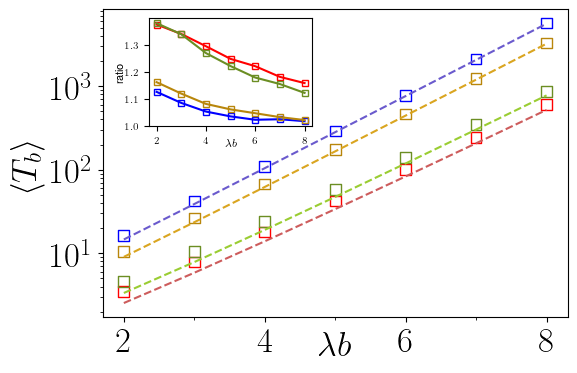

In [250]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

lam = 1.2

fig, ax = plt.subplots(1,1, figsize=(6,4))

ratios = []  # store ratio data for inset
b_all = []   # store corresponding b values

# --- k=3 ---
col1,col2 = colors[0]
mfpt_values = np.load(f"./Data/mfpt-sim-erlang-k{3}-lam{lam}-lambdab{lambda_b}-gamma{1}.npy")
pred_mfpt_values = np.load(f"./Data/mfpt-pred-erlang-k{3}-lam{lam}-lambdab{lambda_b}-gamma{1}.npy")
b_values = np.load(f"./Data/b-values-k{3}-lam{lam}-lambdab{lambda_b}-gamma{1}.npy")

ax.scatter(b_values,mfpt_values,color=col1,marker='s',facecolor='None',s=60)
ax.semilogy(b_values, pred_mfpt_values, '--',color=col2)

ratios.append(mfpt_values/pred_mfpt_values)
b_all.append(b_values)

# --- k=2 ---
col1,col2 = colors[1]
mfpt_values = np.load(f"./Data/mfpt-sim-erlang-k{2}-lam{lam}-lambdab{lambda_b}-gamma{1.5}.npy")
pred_mfpt_values = np.load(f"./Data/mfpt-pred-erlang-k{2}-lam{lam}-lambdab{lambda_b}-gamma{1.5}.npy")
b_values = np.load(f"./Data/b-values-k{2}-lam{lam}-lambdab{lambda_b}-gamma{1.5}.npy")

ax.scatter(b_values,mfpt_values,color=col1,marker='s',facecolor='None',s=60)
ax.semilogy(b_values, pred_mfpt_values, '--',color=col2)

ratios.append(mfpt_values/pred_mfpt_values)
b_all.append(b_values)

# --- k=0.75 ---
col1,col2 = colors[2]
mfpt_values = np.load(f"./Data/mfpt-sim-erlang-k{.75}-lam{lam}-lambdab{lambda_b}-gamma{4.5}.npy")
pred_mfpt_values = np.load(f"./Data/mfpt-pred-erlang-k{.75}-lam{lam}-lambdab{lambda_b}-gamma{4.5}.npy")
b_values = np.load(f"./Data/b-values-k{.75}-lam{lam}-lambdab{lambda_b}-gamma{4.5}.npy")

ax.scatter(b_values,mfpt_values,color=col1,marker='s',facecolor='None',s=60)
ax.semilogy(b_values, pred_mfpt_values, '--',color=col2)

ratios.append(mfpt_values/pred_mfpt_values)
b_all.append(b_values)

# --- k=1 (Poisson) ---
col1,col2 = colors[3]
mfpt_values = np.load(f"./Data/mfpt-sim-erlang-k{1}-lam{lam}-lambdab{lambda_b}-gamma{2.5}.npy")
pred_mfpt_values = np.load(f"./Data/mfpt-pred-erlang-k{1}-lam{lam}-lambdab{lambda_b}-gamma{2.5}.npy")
b_values = np.load(f"./Data/b-values-k{1}-lam{lam}-lambdab{lambda_b}-gamma{2.5}.npy")

ax.scatter(b_values,mfpt_values,color=col1,marker='s',facecolor='None',s=60)
ax.semilogy(b_values, pred_mfpt_values, '--',color=col2)

ratios.append(mfpt_values/pred_mfpt_values)
b_all.append(b_values)

# --- main axis formatting ---
ax.set_xlabel(r"$\lambda b$",labelpad=-20)
ax.set_ylabel(r"$\langle T_b \rangle$")
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

# place inset in upper-left corner, square shape
axins = ax.inset_axes([0.1, 0.62, 0.35, 0.35])  
# [x0, y0, width, height] in axes fraction coords

for b_vals, r_vals, (col1, _) in zip(b_all, ratios, colors):
    axins.plot(b_vals, r_vals, marker='s', ms=5, linestyle='-', color=col1,markerfacecolor='None')

# axins.axhline(1, color='k', linestyle='--', linewidth=1)
axins.set_xlabel(r"$\lambda b$", fontsize=8,labelpad=-5)
axins.set_ylabel(r"ratio", fontsize=8,labelpad=0)
axins.tick_params(axis='both', which='major', labelsize=7)
axins.set


plt.savefig("Figures/mfpt-erlang.pdf", dpi=600, bbox_inches='tight')
plt.show()


## $T_b$ is exponentially dist

In [69]:
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from math import exp, sqrt, log

rng = np.random.default_rng(0)
k=1

def simulate_mfpt_erlang(lam=1.0, gamma=0.5, lambda_b=1.0, b=6.0, trials=20000, seed=0):
    rng = np.random.default_rng(seed)
    T_arr = np.empty(trials, dtype=float)
    w_arr = np.empty(trials, dtype=float)

    for i in range(trials):
        X = 0.0
        t = 0.0
        while True:
            delta = rng.gamma(k, 1/lam)
            X *= math.exp(-gamma * delta)

            B = rng.exponential(scale=1/lambda_b) 

            t += delta
            if X + B >= b:
                break
            else:
                X += B
        T_arr[i] = t

    # importance sampling estimator of MFPT
    mean = np.sum(w_arr * T_arr) / np.sum(w_arr)
    return {"mean_T": mean, "std_T": np.std(T_arr), "samples": T_arr, "n": trials}

# -----------------------------
#  Theory: asymptotic MFPT and C2
# -----------------------------
def predicted_mfpt_erlang(lam=1.0, gamma=0.5, lambda_b=1.0, b=6.0):
    integers_gamma = np.arange(1,int(lambda_b * b)+1)*gamma
    r = lam/k
    return np.exp(lambda_b*b)*np.prod([1-(1/(1+mg/lam))**k for mg in integers_gamma])/r

# -----------------------------
#  Driver
# -----------------------------

# Parameters you can tweak
lam = 1.2       # Erlang scale
gamma = 2.5     # relaxation : better convergence for large gamma, so small relaxation time
lambda_b = 1   # inverse mean mark size
trials = 100000   # Monte Carlo trials per b
seed = 42

# Thresholds to test (larger b -> closer to asymptotic)
b_values = np.arange(8,9,step=1.0)

mfpt_values = np.zeros(b_values.size)
pred_mfpt_values = np.zeros(b_values.size)

print(b_values,mfpt_values)

print(f"Erlang(k={k}) interarrivals, exponential marks -- MFPT verification")
print(f"lam={lam}, gamma={gamma}, lambda_b={lambda_b}, trials={trials}\n")

for i,b in enumerate(b_values):
    pred = predicted_mfpt_erlang(lam=lam, gamma=gamma, lambda_b=lambda_b, b=b)
    # much better to use alpha \approx lam/pred, the probability of an impulse leading to a crossing 
    sim = simulate_mfpt_erlang(lam=lam, gamma=gamma, lambda_b=lambda_b,
                                b=b, trials=trials, seed=seed)
    
    mfpt_values[i] = sim["mean_T"]
    pred_mfpt_values[i] = pred
    ratio = sim["mean_T"] / pred
    print(f"b={b:>4.1f} |  Sim MFPT = {sim['mean_T']: .5f}   "
            f"Pred = {pred: .5f}  |  ratio sim/pred = {ratio: .3f}")




[8.] [0.]
Erlang(k=1) interarrivals, exponential marks -- MFPT verification
lam=1.2, gamma=2.5, lambda_b=1, trials=100000

b= 8.0 |  Sim MFPT =  nan   Pred =  777.09026  |  ratio sim/pred =  nan


C:\Users\julie\AppData\Local\Temp\ipykernel_19252\1691119513.py:34: RuntimeWarning: overflow encountered in multiply
  mean = np.sum(w_arr * T_arr) / np.sum(w_arr)
C:\Users\julie\AppData\Local\Temp\ipykernel_19252\1691119513.py:34: RuntimeWarning: invalid value encountered in multiply
  mean = np.sum(w_arr * T_arr) / np.sum(w_arr)
c:\Users\julie\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\julie\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [70]:
np.save(f"./Data/fpt-samples-erlang-k{k}-lam{lam}-lambdab{lambda_b}-gamma{gamma}.npy",sim["samples"])

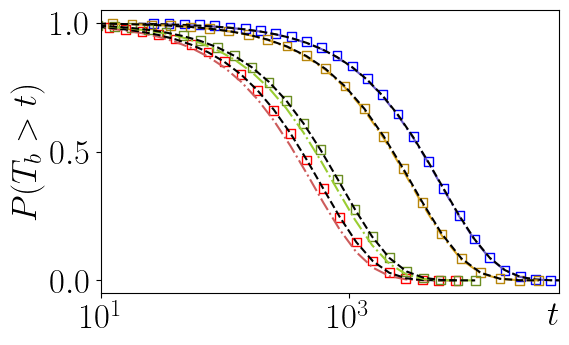

In [97]:
fig, ax = plt.subplots(1,1, figsize=(6,4))


k=3
col1,col2 = colors[0]
gamma=1
samples = np.load(f"./Data/fpt-samples-erlang-k{k}-lam{lam}-lambdab{lambda_b}-gamma{gamma}.npy")
bins=np.logspace(3,np.log(np.max(samples)),base=np.e,num=30)
w,bins = np.histogram(samples,density=1,bins=bins)

plt.scatter(bins[1:],1-np.cumsum(w*np.diff(bins)), marker='s', s=40,facecolor='None',edgecolor=col1)

pred = predicted_mfpt_erlang(lam=lam, gamma=gamma, lambda_b=lambda_b, b=b)
simmfpt = np.mean(samples)

# mean_exp = sim['mfpt_unbiased']
plt.plot(bins,np.exp(-bins/pred), linestyle='-.',color= col2)
plt.plot(bins,np.exp(-bins/simmfpt), linestyle='--',color= 'black')

k=2
col1,col2 = colors[1]
gamma=1.5
samples = np.load(f"./Data/fpt-samples-erlang-k{k}-lam{lam}-lambdab{lambda_b}-gamma{gamma}.npy")
bins=np.logspace(0,np.log(np.max(samples)),base=np.e,num=30)
w,bins = np.histogram(samples,density=1,bins=bins)

plt.scatter(bins[1:],1-np.cumsum(w*np.diff(bins)), marker='s', s=40,facecolor='None',edgecolor=col1)

pred = predicted_mfpt_erlang(lam=lam, gamma=gamma, lambda_b=lambda_b, b=b)
simmfpt = np.mean(samples)

# mean_exp = sim['mfpt_unbiased']
plt.plot(bins,np.exp(-bins/pred), linestyle='-.',color=col2)
plt.plot(bins,np.exp(-bins/simmfpt), linestyle='--',color= 'black')

k=.75
col1,col2 = colors[2]
gamma=4.5
samples = np.load(f"./Data/fpt-samples-erlang-k{k}-lam{lam}-lambdab{lambda_b}-gamma{gamma}.npy")

bins=np.logspace(0,np.log(np.max(samples)),base=np.e,num=30)
w,bins = np.histogram(samples,density=1,bins=bins)

plt.scatter(bins[1:],1-np.cumsum(w*np.diff(bins)), marker='s', s=40,facecolor='None', edgecolor=col1)
pred = predicted_mfpt_erlang(lam=lam, gamma=gamma, lambda_b=lambda_b, b=b)
simmfpt = np.mean(samples)

plt.plot(bins,np.exp(-bins/pred), linestyle='-.',color= col2)
plt.plot(bins,np.exp(-bins/simmfpt), linestyle='--',color= 'black')

k=1
col1,col2 = colors[3]
gamma=2.5
samples = np.load(f"./Data/fpt-samples-erlang-k{k}-lam{lam}-lambdab{lambda_b}-gamma{gamma}.npy")

bins=np.logspace(0,np.log(np.max(samples)),base=np.e,num=30)
w,bins = np.histogram(samples,density=1,bins=bins)

plt.scatter(bins[1:],1-np.cumsum(w*np.diff(bins)), marker='s', s=40,facecolor='None', edgecolor=col1)
pred = predicted_mfpt_erlang(lam=lam, gamma=gamma, lambda_b=lambda_b, b=b)
simmfpt = np.mean(samples)

plt.plot(bins,np.exp(-bins/pred), linestyle='-.',color= col2)
plt.plot(bins,np.exp(-bins/simmfpt), linestyle='--',color= 'black')

plt.tight_layout()
# ax.set_xlim(0,18000)

ax.set_xlim(1e1,5e4)
ax.set_xlabel("$t$",loc='right',labelpad=-25)
ax.set_ylabel("$P(T_b > t)$")
plt.semilogx()
plt.savefig("Figures/exp-dist-Tb.pdf", dpi=600, bbox_inches='tight')
plt.show()

# Erlang $k=2$

## Moments

In [4]:
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from math import exp, sqrt, log

rng = np.random.default_rng(0)

def erlang2_gap(lam):
    """Return one Erlang(k=2, rate=lam) interarrival time."""
    return rng.exponential(1.0 / lam) + rng.exponential(1.0 / lam)

def sample_preburst_stat(lam, gamma, M_b, n_trials=50000, burn=200):
    samples = []
    for trial in range(n_trials):
        X = 0.0
        # burn-in
        for _ in range(burn):
            W = erlang2_gap(lam)
            X *= math.exp(-gamma * W)
            X += rng.exponential(M_b)
        # collect pre-burst values
        
        W = erlang2_gap(lam)
        X *= math.exp(-gamma * W)
        samples.append(X)         # record pre-burst state
            
    return samples


lam = 3.0                 # rate
gamma = 0.5       # relaxation
M_b = 1                 # mean burst size

x_samples = sample_preburst_stat(lam,gamma,M_b)

In [5]:
def psi_erlang(s,lam):
    return lam**2 / (s**2 + 2*s*lam)

th_mean = psi_erlang(gamma,lam)*M_b
th_var = 2*M_b**2*psi_erlang(2*gamma,lam)*(1+psi_erlang(gamma,lam))-th_mean**2

print(f"Simulated mean : {np.mean(x_samples)}; Simulated var : {np.var(x_samples)}")
print(f"Theoretical mean : {th_mean}; Theoretical var : {th_var}")

Simulated mean : 2.7623672404065567; Simulated var : 2.0092196161502103
Theoretical mean : 2.769230769230769; Theoretical var : 2.0236686390532563


## MFPT

In [ ]:
import math
import numpy as np


def erlang2_gap(lam, rng):
    """Return one Erlang(k=2, rate=lam) interarrival time."""
    return rng.exponential(1.0 / lam) + rng.exponential(1.0 / lam)


def simulate_mfpt_erlang2(lam=1.0, gamma=0.5, lambda_b=1.0, b=6.0, trials=20000, seed=0):
    rng = np.random.default_rng(seed)
    T_arr = np.empty(trials, dtype=float)
    w_arr = np.empty(trials, dtype=float)

    eta = 0.1 / lambda_b
    lambda_q = lambda_b / (1 - lambda_b * eta)

    for i in range(trials):
        X = 0.0
        t = 0.0
        logw = 0.0
        while True:
            delta = erlang2_gap(lam, rng)
            X *= math.exp(-gamma * delta)

            B = rng.exponential(scale=lambda_b) 

            t += delta
            if X + B >= b:
                break
            else:
                X += B
        T_arr[i] = t
        w_arr[i] = math.exp(logw)

    # importance sampling estimator of MFPT
    mean = np.sum(w_arr * T_arr) / np.sum(w_arr)
    return {"mean_T": mean, "std_T": np.std(T_arr), "samples": T_arr, "weights": w_arr, "n": trials}

def predicted_mfpt_erlang2(lam=1.0, gamma=0.5, lambda_b=1.0, b=6.0):
    """
    Return (predicted_MFPT, C2, mu, a) where:
        a  = lam / gamma
        mu = 2 / lam
        C2 = Gamma(1 + 2a) / Gamma(1 + a)^2
        predicted_MFPT = (mu / C2) * exp(b / lambda_b)
    """
    a = lam / gamma
    mu = 2.0 / lam
    C2 = math.gamma(1.0 + 2.0 * a) / (math.gamma(1.0 + a) ** 2)
    return (mu / C2) * math.exp(b / lambda_b), C2, mu, a

# -----------------------------
#  Driver
# -----------------------------

# Parameters you can tweak
lam = 1.2       # Erlang-2 rate
gamma = 3.      # relaxation : better convergence for large gamma, so small relaxation time
lambda_b = 1   # mean mark size
trials = 10000   # Monte Carlo trials per b
seed = 42

# Thresholds to test (larger b -> closer to asymptotic)
b_values = np.arange(5,6,step=1.0)
b_values = np.array([6])
mfpt_values = np.zeros(b_values.size)
pred_mfpt_values = np.zeros(b_values.size)

print(b_values,mfpt_values)

print("Erlang(k=2) interarrivals, exponential marks -- MFPT verification")
print(f"lam={lam}, gamma={gamma}, lambda_b={lambda_b}, trials={trials}\n")

# Theoretical Palm constant and predicted MFPT
for i,b in enumerate(b_values):
    pred, C2, mu, a = predicted_mfpt_erlang2(lam=lam, gamma=gamma, lambda_b=lambda_b, b=b)
    # much better to use alpha \approx lam/pred, the probability of an impulse leading to a crossing 
    sim = simulate_mfpt_erlang2(lam=lam, gamma=gamma, lambda_b=lambda_b,
                                b=b, trials=trials, seed=seed)
    
    mfpt_values[i] = sim["mfpt_unbiased"]
    pred_mfpt_values[i] = pred
    ratio = sim["mfpt_unbiased"] / pred
    print(f"b={b:>4.1f} |  Sim MFPT = {sim['mfpt_unbiased']: .5f}   "
            f"Pred = {pred: .5f}  |  ratio sim/pred = {ratio: .3f}")


[6] [0.]
Erlang(k=2) interarrivals, exponential marks -- MFPT verification
lam=1.2, gamma=3.0, lambda_b=1, trials=10000



KeyboardInterrupt: 

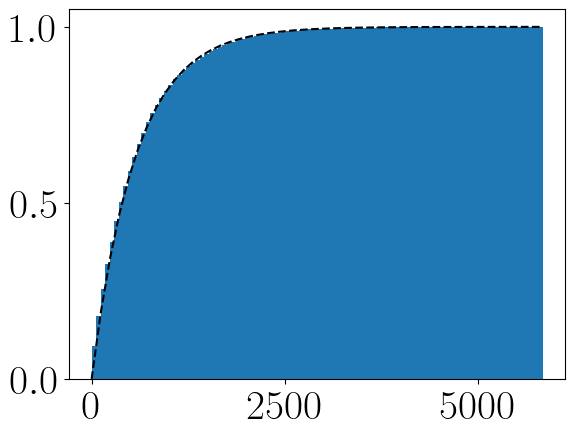

In [ ]:
plt.hist(sim["times"],density=1,bins=100,cumulative=1,weights=np.exp(sim["log_weights"]))
t = np.linspace(0,np.max(sim['times']))
pred, C2, mu, a = predicted_mfpt_erlang2(lam=lam, gamma=gamma, lambda_b=lambda_b, b=b)
mean_exp = sim['mfpt_unbiased']
plt.plot(t,1- np.exp(-t/pred), linestyle='--',color= 'black')
# plt.plot(t,1- np.exp(-t/mean_exp))
plt.show()

2.455752241237877


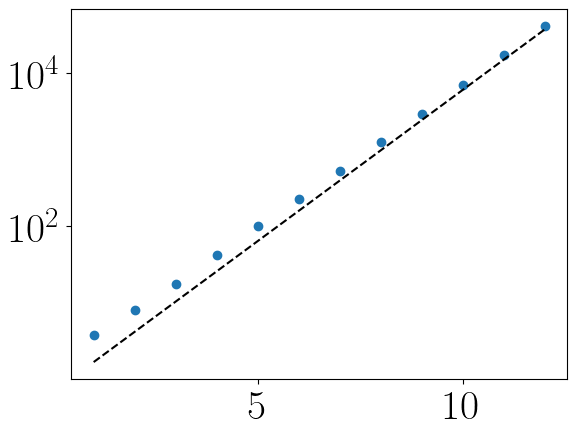

In [ ]:
plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,pred_mfpt_values,'--k')
print(C2)
# plt.plot(b_values,mfpt_values/pred_mfpt_values)

plt.savefig(f"Figures/mfpt_erlang_2_gamma{gamma}_lambda{lam}_lambdab{lambda_b}.pdf", dpi=600, bbox_inches='tight')

# Returns with $\frac{1}{2} < \kappa<1$

In [81]:
kappa=0.9

import scipy.special as sp

# ---- hatψ(s): vectorized, with small-s safeguard ----
def hatpsi_vec(s):
    s = np.asarray(s, dtype=float)

    # erf for arrays without SciPy
    gamma_u = sp.gamma
    gammainc_u = sp.gammainc

    num = s**(-kappa) * kappa * gamma_u(kappa) * (gammainc_u(kappa,s))
    # denom_term = 1 - (sqrt(pi)*erf(sqrt(s)))/(2*sqrt(s))
    denom_term = 1.0 - num

    return num/denom_term

# ---- B1 estimator: grows n, accumulates sum log(1+hatψ(mγ)), checks convergence ----
def estimate_B1(gamma, max_n=2_000_00,  # up to ~200k terms by default
                block=2000, tol=1e-8, verbose=False):
    """
    Returns (B1_estimate, log_B1_estimate, n_used).
    Assumes kappa < 1 (the B1-regime).
    """
    assert gamma > 0.0 and kappa < 1.0

    const = math.gamma(1+kappa) / ((1.0 - kappa) * (gamma ** kappa))
    sum_logs = 0.0
    prev_B = None
    n_used = 1

    for start in range(1, max_n, block):
        stop = min(start + block - 1, max_n - 1)  # product up to n-1
        m = np.arange(start, stop + 1, dtype=float)
        s = m * gamma
        hp = hatpsi_vec(s)
        sum_logs += np.sum(np.log1p(hp))  # log(1 + hatψ)

        n = stop + 1
        log_Bn = const * (n ** (1.0 - kappa)) - sum_logs
        Bn = math.exp(log_Bn)

        if verbose and n % (10 * block) == 0:
            print(f"n={n:8d}, Bn={Bn:.8e}")

        if prev_B is not None:
            if abs(Bn - prev_B) / max(1.0, abs(prev_B)) < tol:
                n_used = n
                return Bn, log_Bn, n_used
        prev_B = Bn
        n_used = n

    return prev_B, log_Bn, n_used


In [216]:

def bursty(rng):
    """Return one 1/2/sqrt(t) interarrival time."""
    return rng.uniform()**(1/kappa)


def simulate_mfpt_bursty(gamma=0.5, lambda_b=1.0, b=6.0, trials=20000, seed=0):
    rng = np.random.default_rng(seed)
    T_arr = np.empty(trials, dtype=float)

    for i in range(trials):
        X = 0.0
        t = 0.0
        while True:
            delta = bursty(rng)
            X *= math.exp(-gamma * delta)

            B = rng.exponential(scale=lambda_b) 
            t += delta
            if X + B >= b:
                break
            else:
                X += B
        T_arr[i] = t
    mean = np.mean(T_arr)
    return {"mean_T": mean, "std_T": np.std(T_arr), "samples": T_arr, "n": trials}

def predicted_mfpt_bursty(gamma=0.5, lambda_b=1.0, b=6.0):
    const = (math.gamma(1+kappa)/(1-kappa) )/gamma**(kappa)
    return np.exp(b/lambda_b - const * (b/lambda_b)**(1-kappa))



# Parameters you can tweak
lam = 1.       # Erlang-2 rate
gamma = 4      # relaxation : better convergence for large gamma, so small relaxation time
lambda_b = 1   # mean mark size
trials = 1000   # Monte Carlo trials per b
seed = 42

# Thresholds to test (larger b -> closer to asymptotic)
b_values = np.arange(5,15,step=2)

mfpt_values = np.zeros(b_values.size)
pred_mfpt_values = np.zeros(b_values.size)

print(b_values,mfpt_values)

print("Bursty interarrivals, exponential marks -- MFPT verification")
print(f"lam={lam}, gamma={gamma}, lambda_b={lambda_b}, trials={trials}\n")

# Theoretical Palm constant and predicted MFPT
for i,b in enumerate(b_values):
    pred = predicted_mfpt_bursty(gamma=gamma, lambda_b=lambda_b, b=b)
    # much better to use alpha \approx lam/pred, the probability of an impulse leading to a crossing 
    sim = simulate_mfpt_bursty(gamma=gamma, lambda_b=lambda_b,
                                b=b, trials=trials, seed=seed)
    
    mfpt_values[i] = sim["mean_T"]
    pred_mfpt_values[i] = pred
    ratio = sim["mean_T"] / pred
    print(f"b={b:>4.1f} |  Sim MFPT = {sim['mean_T']: .5f}   "
            f"Pred = {pred: .5f}  |  ratio sim/pred = {ratio: .3f}")

[ 5  7  9 11 13] [0. 0. 0. 0. 0.]
Bursty interarrivals, exponential marks -- MFPT verification
lam=1.0, gamma=4, lambda_b=1, trials=1000



NameError: name 'kappa' is not defined

2.111111111111111
2567.5248969143113


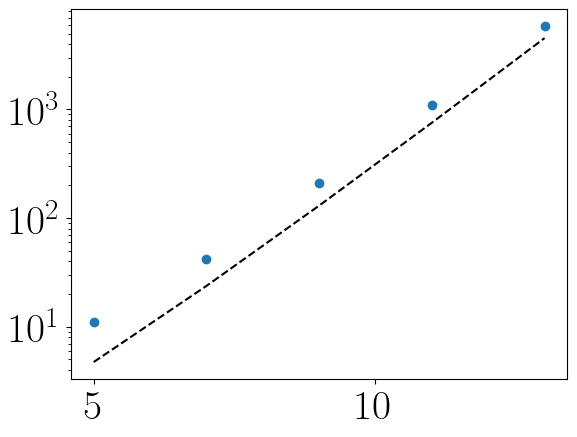

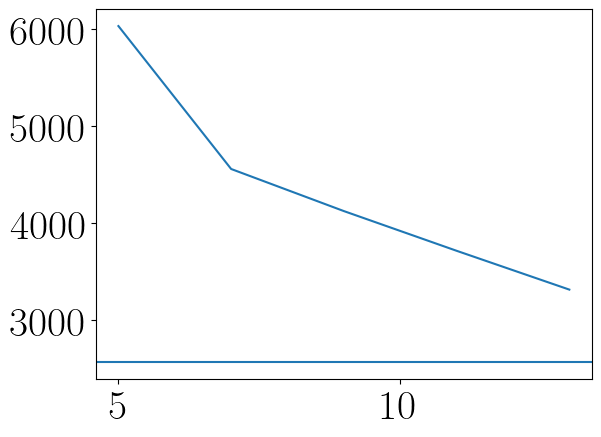

In [91]:
b1 = estimate_B1(gamma)[0]
r = (1+1/kappa)
print(r)
const = b1/r
print(const)

plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,const*pred_mfpt_values,'--k')
plt.show()

plt.plot(b_values, mfpt_values / pred_mfpt_values)
plt.axhline(const)

C:\Users\julie\AppData\Local\Temp\ipykernel_21452\3072886040.py:5: RuntimeWarning: divide by zero encountered in power
  plt.plot(t,kappa * t**(kappa-1))


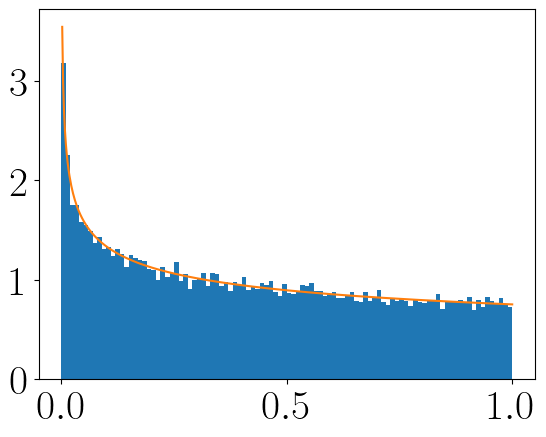

In [306]:
kappa=3/4
samples = [bursty(rng) for i in range(50000)]
t=np.linspace(0,1,500)
plt.hist(samples,density=1,bins=100)
plt.plot(t,kappa * t**(kappa-1))
plt.show()

# Returns with $\kappa=1/2$

In [ ]:
# ---- hatψ(s): vectorized, with small-s safeguard ----
def hatpsi_vec(s):
    s = np.asarray(s, dtype=float)
    u = np.sqrt(s)

    # erf for arrays without SciPy
    erf_u = np.vectorize(math.erf)(u)

    num = np.sqrt(np.pi) * erf_u
    # denom_term = 1 - (sqrt(pi)*erf(sqrt(s)))/(2*sqrt(s))
    denom_term = 1.0 - num / (2.0 * np.where(u == 0.0, np.inf, u))

    out = np.empty_like(s)
    # small-s asymptotic: hatψ(s) ~ 3/s as s -> 0
    small = s < 1e-12
    out[small] = 3.0 / s[small]

    ok = ~small
    out[ok] = num[ok] / (2.0 * u[ok] * denom_term[ok])
    return out

# ---- B1 estimator: grows n, accumulates sum log(1+hatψ(mγ)), checks convergence ----
def estimate_B1(c, kappa, gamma, max_n=2_000_00,  # up to ~200k terms by default
                block=2000, tol=1e-8, verbose=False):
    """
    Returns (B1_estimate, log_B1_estimate, n_used).
    Assumes kappa < 1 (the B1-regime).
    """
    assert gamma > 0.0 and kappa < 1.0

    const = c * math.gamma(kappa) / ((1.0 - kappa) * (gamma ** kappa))
    sum_logs = 0.0
    prev_B = None
    n_used = 1

    for start in range(1, max_n, block):
        stop = min(start + block - 1, max_n - 1)  # product up to n-1
        m = np.arange(start, stop + 1, dtype=float)
        s = m * gamma
        hp = hatpsi_vec(s)
        sum_logs += np.sum(np.log1p(hp))  # log(1 + hatψ)

        n = stop + 1
        log_Bn = const * (n ** (1.0 - kappa)) - sum_logs + (np.pi/8/gamma)*np.log(n)
        Bn = math.exp(log_Bn)

        if verbose and n % (10 * block) == 0:
            print(f"n={n:8d}, Bn={Bn:.8e}")

        if prev_B is not None:
            if abs(Bn - prev_B) / max(1.0, abs(prev_B)) < tol:
                n_used = n
                return Bn, log_Bn, n_used
        prev_B = Bn
        n_used = n

    return prev_B, log_Bn, n_used

# ---- example usage ----
if __name__ == "__main__":
    # For your specific hatψ(s) (which has asymptotic κ = 1/2 with c = 1),
    # a natural test is kappa=0.5, c=1.0. Choose any gamma > 0.
    c = 1/2
    kappa = 0.5

    B1, logB1, n = estimate_B1(c, kappa, gamma, max_n=2000000, block=4000, tol=1e-6, verbose=True)
    print(f"\nB1 ≈ {B1:.10g} (log B1 = {logB1:.10g}), using n = {n}")



B1 ≈ 1.734707981 (log B1 = 0.5508390887), using n = 972001


In [215]:
import scipy.special as sp
def bursty(rng):
    """Return one 1/2/sqrt(t) interarrival time."""
    return rng.uniform()**2


def simulate_mfpt_bursty(gamma=0.5, lambda_b=1.0, b=6.0, trials=20000, seed=0):
    rng = np.random.default_rng(seed)
    T_arr = np.empty(trials, dtype=float)

    for i in range(trials):
        X = 0.0
        t = 0.0
        while True:
            delta = bursty(rng)
            X *= math.exp(-gamma * delta)

            B = rng.exponential(scale=lambda_b) 
            t += delta
            if X + B >= b:
                break
            else:
                X += B
        T_arr[i] = t
    mean = np.mean(T_arr)
    return {"mean_T": mean, "std_T": np.std(T_arr), "samples": T_arr, "n": trials}

def predicted_mfpt_bursty(gamma=0.5, lambda_b=1.0, b=6.0):
    # return np.exp(b/lambda_b - np.sqrt((np.pi/gamma) * (b/lambda_b)))/(b/lambda_b)**(np.pi/8/gamma)
    integers_gamma = np.arange(1,int(lambda_b * b)+1)*gamma
    r = 3
    return np.exp(lambda_b*b)*np.prod([1-np.sqrt(np.pi)*sp.erf(np.sqrt(mg))/2/np.sqrt(mg) for mg in integers_gamma])/r



# Parameters you can tweak
lam = 1.       # Erlang-2 rate
gamma = 4.      # relaxation : better convergence for large gamma, so small relaxation time
lambda_b = 1   # mean mark size
trials = 50000   # Monte Carlo trials per b
seed = 42

# Thresholds to test (larger b -> closer to asymptotic)
b_values = np.arange(2,14,step=2.0)

mfpt_values = np.zeros(b_values.size)
pred_mfpt_values = np.zeros(b_values.size)

print(b_values,mfpt_values)

print("Bursty interarrivals, exponential marks -- MFPT verification")
print(f"lam={lam}, gamma={gamma}, lambda_b={lambda_b}, trials={trials}\n")

# Theoretical Palm constant and predicted MFPT
for i,b in enumerate(b_values):
    pred = predicted_mfpt_bursty(gamma=gamma, lambda_b=lambda_b, b=b)
    # much better to use alpha \approx lam/pred, the probability of an impulse leading to a crossing 
    sim = simulate_mfpt_bursty(gamma=gamma, lambda_b=lambda_b,
                                b=b, trials=trials, seed=seed)
    
    mfpt_values[i] = sim["mean_T"]
    pred_mfpt_values[i] = pred
    ratio = sim["mean_T"] / pred
    print(f"b={b:>4.1f} |  Sim MFPT = {sim['mean_T']: .5f}   "
            f"Pred = {pred: .5f}  |  ratio sim/pred = {ratio: .3f}")

[ 2.  4.  6.  8. 10. 12.] [0. 0. 0. 0. 0. 0.]
Bursty interarrivals, exponential marks -- MFPT verification
lam=1.0, gamma=4.0, lambda_b=1, trials=50000

b= 2.0 |  Sim MFPT =  1.64230   Pred =  0.94539  |  ratio sim/pred =  1.737
b= 4.0 |  Sim MFPT =  6.76946   Pred =  4.04666  |  ratio sim/pred =  1.673
b= 6.0 |  Sim MFPT =  30.25006   Pred =  19.63843  |  ratio sim/pred =  1.540
b= 8.0 |  Sim MFPT =  148.35718   Pred =  101.88031  |  ratio sim/pred =  1.456


KeyboardInterrupt: 

C:\Users\julie\AppData\Local\Temp\ipykernel_21452\2292213041.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(t,1/2/np.sqrt(t))


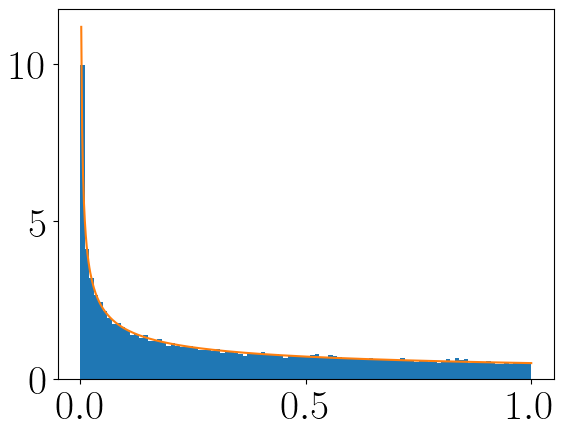

In [ ]:
# the density of tau is indeed 1/2/sqrt(tau)
samples = [bursty(rng) for i in range(50000)]
t=np.linspace(0,1,500)
plt.hist(samples,density=1,bins=100)
plt.plot(t,1/2/np.sqrt(t))
plt.show()

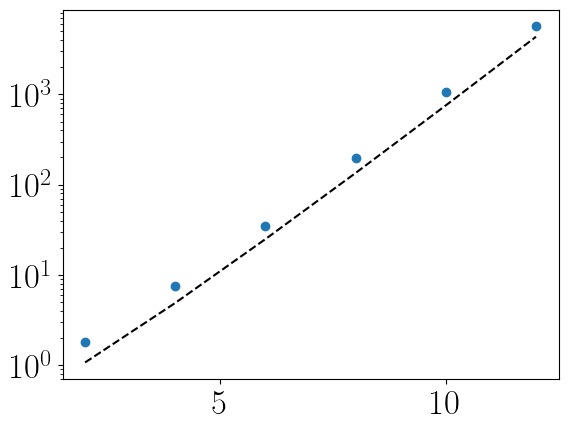

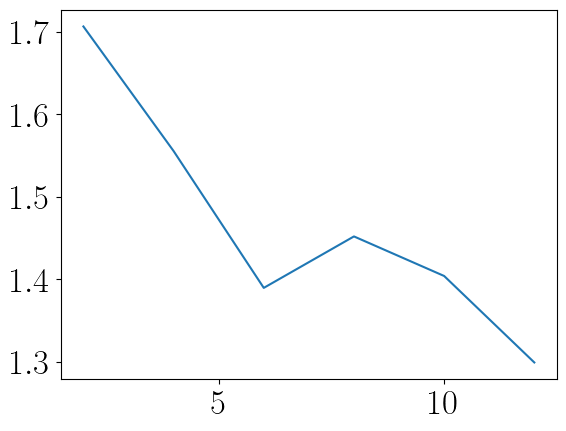

In [212]:
# B1 = estimate_B1(c=1/2,kappa=1/2,gamma=gamma,max_n=2000000)[0]
plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,pred_mfpt_values,'--k')
plt.show()

plt.plot(b_values, mfpt_values / pred_mfpt_values)


# Impulses generated by a RW
Setting : RW on a ring with $L$ sites. Waiting time b/w jumps is set to $1$. Every time the RW visits the origin, the shot process receives an impulse that is exponentially distributed with mean $M_b$.

We choose the length and relaxation rate $\gamma$ so that $L^2 \gamma \approx 1$ (possibly more than 1). This way, the return probability $\psi(t) = P(0|0,t)$ behaves as $t^{-1/2}$ for a large class of values $1 \ll t \ll L^2$, and thus the relevant terms $\hat{\psi}(m \gamma) \propto (\gamma m)^{-1/2}$ for $m<m_* = L^2 = \frac{1}{\gamma}$ very large. This enhances the MFPT to levels $1 \ll \frac{b}{M_b} \ll L^2$.

## Check moments

In [29]:
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from math import exp, sqrt, log

rng = np.random.default_rng(0)

import math, numpy as np

def _excursion_time_on_cycle(L, rate, rng):
    """
    Continuous-time simple random walk on a cycle of length L.
    Excursion time = time from leaving 0 to the next return to 0.
    Each step occurs after Exp(rate); step is ±1 with prob 1/2.
    """
    # Leave 0 with one step
    t = rng.exponential(1.0 / rate)
    pos = 1 if (rng.random() < 0.5) else (L - 1)
    # Walk until return to 0
    while pos != 0:
        t += rng.exponential(1.0 / rate)
        if rng.random() < 0.5:
            pos = (pos + 1) % L
        else:
            pos = (pos - 1) % L
    return t

def sample_preburst_stat_circle(L, gamma, M_b, n_samples=20000, burn_cycles=200, step_rate=1.0, seed=0):
    """
    Stationary pre-burst samples for shot noise driven by return-to-0 times
    of a continuous-time simple random walk on a cycle of length L.
    
    - Between arrivals, X decays: X <- X * exp(-gamma * T_excursion).
    - At arrival (return to 0), we record pre-burst X^- and then add a burst Z ~ Exp(mean=M_b).
    - 'burn_cycles' excursions are used to reach stationarity (Palm).
    - Then we record 'n_samples' pre-burst values.
    """
    rng = np.random.default_rng(seed)
    samples = []
    for _ in range(n_samples):
        X = 0.0

        # Burn-in: run many excursions, always adding the burst after returning to 0
        for _ in range(burn_cycles):
            T = _excursion_time_on_cycle(L, step_rate, rng)
            X *= math.exp(-gamma * T)      # pre-burst at arrival (not recorded during burn)
            Z = rng.exponential(M_b)
            X += Z                         # post-burst; continue

        T = _excursion_time_on_cycle(L, step_rate, rng)
        X *= math.exp(-gamma * T)      # THIS is the pre-burst value at arrival
        samples.append(X)

    return np.array(samples, dtype=float)

def psih(s,L):
    xi = 1/(1+s)
    u = (1-np.sqrt(1-xi**2))/xi
    return (1+u**L)/(1-u**L)/np.sqrt(1-xi**2)-1

L = 3                    # ring size
gamma = .2       # relaxation matched to diffusion timescale
M_b = 1                 # mean burst size

x_samples = sample_preburst_stat_circle(L,gamma,M_b)

In [30]:
th_mean = psih(gamma,L)*M_b
th_var = 2*M_b**2*psih(2*gamma,L)*(1+psih(gamma,L))-th_mean**2

print(f"Simulated mean : {np.mean(x_samples)}; Simulated var : {np.var(x_samples)}")
print(f"Theoretical mean : {th_mean}; Theoretical var : {th_var}")

Simulated mean : 1.4706192268345173; Simulated var : 1.0847454382775323
Theoretical mean : 1.4705882352941173; Theoretical var : 1.088144236022583


## Compute MFPT

In [154]:
# Simulation of conventional shot noise driven by a continuous-time random walk (CTRW) on a ring.
# - CTRW: L sites, exponential holding time with mean tau_w=1 before each ±1 jump.
# - Each *arrival at site 0* generates a burst Z ~ Exp(mean = M_b).
# - Between arrivals, the shot-noise amplitude X(t) decays exponentially with rate gamma.
# - We estimate the MFPT to cross a threshold b, starting from X(0)=0 at site 0 (no initial burst).
#
# We'll sweep a few b values in the mesoscopic window 1 << b/M_b << L^2 and compare:
#  (i) empirical log MFPT;
#  (ii) a simple Arrhenius-only predictor: log T ≈ log(1/r) + b/M_b, with r ≈ 1/L;
#  (iii) a geometry-corrected heuristic: log T ≈ log(1/r) + b/M_b - S(n*),
#       where S(n*) = sum_{m=1}^{n*} log(1 + L/sqrt(2m)), and n* = floor(b/M_b).
#
# Note: (iii) is a practical, "saddle-index" approximation using the ψ_hat ~ L/sqrt(2m) window,
# meant to visualize the geometry-induced suppression discussed in the analysis.
# It is not a rigorous bound; it's a useful diagnostic to see qualitative trends.

import numpy as np
import math
import random
import time
import pandas as pd
from math import exp, sqrt, log

rng = np.random.default_rng(0)

def _excursion_time_on_cycle(L, rate):
    """
    Continuous-time simple random walk on a cycle of length L.
    Excursion time = time from leaving 0 to the next return to 0.
    Each step occurs after Exp(rate); step is ±1 with prob 1/2.
    """
    # Leave 0 with one step
    t = rng.exponential(1.0 / rate)
    pos = 1 if (rng.random() < 0.5) else (L - 1)
    # Walk until return to 0
    while pos != 0:
        t += rng.exponential(1.0 / rate)
        if rng.random() < 0.5:
            pos = (pos + 1) % L
        else:
            pos = (pos - 1) % L
    return t

def simulate_mfpt(L, gamma, M_b, b, n_trials=2000):
    """
    Simulate the MFPT to threshold b for the conventional shot noise with
    bursts at each visit to site 0 by a continuous-time simple random walk on a ring.
    
    Parameters:
        L (int): number of sites on the ring
        gamma (float): relaxation rate of the shot noise
        M_b (float): mean burst size (Exponential marks)
        b (float): threshold
        n_trials (int): number of independent simulation runs
        max_visits (int): safety cap on the number of visit cycles
        
    Returns:
        mean_T (float): empirical mean first-passage time
        times (np.ndarray): individual first-passage times
    """
    times = np.empty(n_trials, dtype=float)
    for trial in range(n_trials):
        # Initialize
        X = 0.0
        t = 0.0

        # Burn-in: run many excursions, always adding the burst after returning to 0
        while X<b:
            T = _excursion_time_on_cycle(L, 1)
            t+=T
            X *= math.exp(-gamma * T)      # pre-burst at arrival (not recorded during burn)
            Z = rng.exponential(M_b)
            X += Z  

        times[trial] = t
    mean_T = float(np.mean(times))
    return mean_T, times

def arrhenius_only_logT(L, M_b, b):
    # r ≈ 1/L for CTRW on ring with tau_w=1: inter-visit mean ≈ L
    r = 1.0 / L
    return math.log(1.0/r) + b / M_b  # log(1/r) + b/M_b

def psih(s,L):
    xi = 1/(1+s)
    u = (1-np.sqrt(1-xi**2))/xi
    return (1+u**L)/(1-u**L)/np.sqrt(1-xi**2)-1

def geometry_corrected_logT(L, M_b, b):
    # Heuristic "saddle-index" correction using ψ_hat ≈ L / sqrt(2 m) for m <= n*
    r = 1.0 / L
    # S = 1+psih(gamma,L)
    # last_term = psih(gamma,L)
    # for n in range(2,int(b/M_b)+1):
    #     last_term = (1+psih((n-1)*gamma,L)) * last_term * psih(n*gamma,L) / psih((n-1)*gamma,L)
    #     S += last_term
    S = np.prod([1+psih(m*gamma,L) for m in range(1,int(b/M_b)+1)])
    # return math.log(1.0/r) + b / M_b - L*np.sqrt(2*b/M_b) + ((L**2) /4)*np.log(b/M_b)
    return b/M_b - np.log(S) - np.log(r)

# Choose parameters in the mesoscopic window:
L = 3                    # ring size
gamma = 2       # relaxation matched to diffusion timescale
M_b = 1                 # mean burst size
b_values = np.linspace(1,.5*L**2,num=8)*M_b  # thresholds; ensure 1 << b/M_b << L^2
n_trials = 50000


results = []
start = time.time()
for b in b_values:
    print(b)
    mean_T, times = simulate_mfpt(L=L, gamma=gamma, M_b=M_b, b=b, n_trials=n_trials)
    logT_emp = math.log(mean_T)
    logT_arr = arrhenius_only_logT(L, M_b, b)
    logT_geom = geometry_corrected_logT(L, M_b, b)
    results.append({
        "L": L,
        "gamma": gamma,
        "M_b": M_b,
        "b": b,
        "b/M_b": b / M_b,
        "MFPT_mean": mean_T,
        "log_MFPT_emp": logT_emp,
        "logT_arrhenius": logT_arr,
        "logT_geom_corrected": logT_geom,
        "n_trials": n_trials
    })
elapsed = time.time() - start


1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5


Testing the asymptotics of the mgf

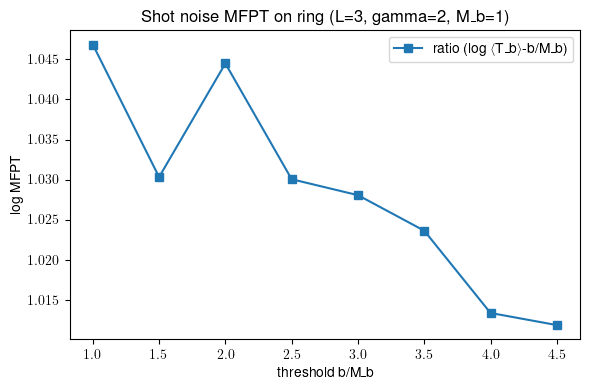

Finished in 31.2s


In [155]:
df = pd.DataFrame(results)
# Plot log MFPT vs b with predictors
plt.figure(figsize=(6,4))
plt.plot(df["b/M_b"], (df["log_MFPT_emp"]-df["b/M_b"])/(df["logT_geom_corrected"]-df["b/M_b"]), marker="s", label="ratio (log ⟨T_b⟩-b/M_b)")
# plt.plot(df["b/M_b"], df["logT_geom_corrected"]-df["b/M_b"], marker="o", label="geom.-corrected")
# plt.plot(df["b/M_b"], df["log_MFPT_emp"]-df["b/M_b"], marker="s", label="empirical log ⟨T_b⟩")

plt.xlabel("threshold b/M_b")
plt.ylabel("log MFPT")
plt.title(f"Shot noise MFPT on ring (L={L}, gamma={gamma:.4g}, M_b={M_b})")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Finished in {elapsed:.1f}s")

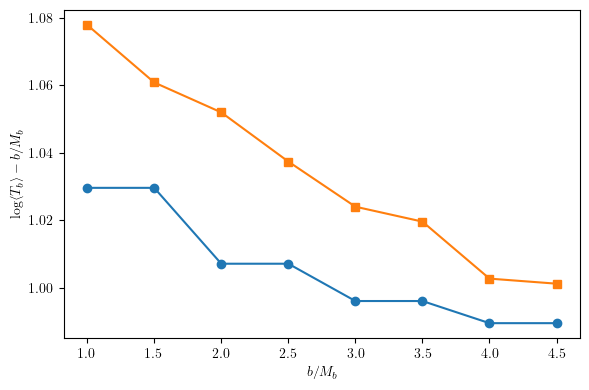

Finished in 31.2s


In [156]:
df = pd.DataFrame(results)
# Plot log MFPT vs b with predictors
plt.figure(figsize=(6,4))

plt.plot(df["b/M_b"], df["logT_geom_corrected"]-df["b/M_b"], marker="o", label="th. (no Arrhenius factor)")
plt.plot(df["b/M_b"], df["log_MFPT_emp"]-df["b/M_b"], marker="s", label="empirical (no Arrhenius factor)")

plt.xlabel("$b/M_b$")
plt.ylabel("$\log \langle T_b \\rangle - b/M_b$")
# plt.title(f"Shot noise MFPT on ring (L={L}, gamma={gamma:.4g}, M_b={M_b})")
# plt.legend()
plt.tight_layout()
plt.show()

print(f"Finished in {elapsed:.1f}s")

Fit parameters:
C1 = 3.952, C2 = 3.095,C3 = 1.147
3.952167573337192 2.449489742783178 2.25


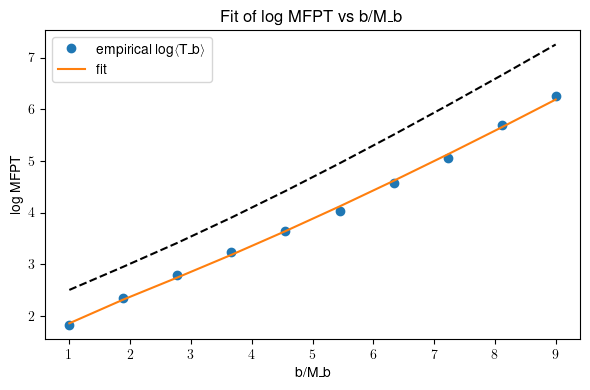

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# Example dataframe df with empirical MFPT results
# You need columns: "b", "M_b", "log_MFPT_emp"
# df["b/M_b"] = df["b"] / df["M_b"]

# Define the fit function
def fit_func(x, C1, C2, C3):
    return C1 + x - C2 * (x ** (1/2)) + C3 * np.log(x)
    

# Independent variable and data
xdata = df["b/M_b"].values
ydata = df["log_MFPT_emp"].values

# Initial guesses and parameter bounds
p0 = [0.0, 1.0, 1.0]
bounds = ([-np.inf, 0, 0], [np.inf, np.inf, np.inf])

# Fit
popt, pcov = curve_fit(fit_func, xdata, ydata, p0=p0, bounds=bounds, maxfev=20000)
C1, C2,C3 = popt

# Predicted values
yfit = fit_func(xdata, *popt)

ytest = fit_func(xdata, *[C1, np.sqrt(2*L),L/4])

print("Fit parameters:")
print(f"C1 = {C1:.3f}, C2 = {C2:.3f},C3 = {C3:.3f}")
print(C1, np.sqrt(2*L), L**2/4)

# Plot empirical data vs fit
plt.figure(figsize=(6,4))
plt.plot(xdata, ydata, "o", label="empirical log⟨T_b⟩")
plt.plot(xdata, yfit, "-", label="fit")
plt.plot(xdata, ytest, "--k")
plt.xlabel("b/M_b")
plt.ylabel("log MFPT")
plt.legend()
plt.title("Fit of log MFPT vs b/M_b")
plt.tight_layout()
plt.show()


In [87]:
# np.save(f"./Data/rw_L_{L}_boverMb.npy",df["b/M_b"].values)
# np.save(f"./Data/rw_L_{L}_logmfpt.npy",df["log_MFPT_emp"].values)

boverMb = np.load(f"./Data/rw_L_{L}_boverMb.npy")
logmfpt = np.load(f"./Data/rw_L_{L}_logmfpt.npy")


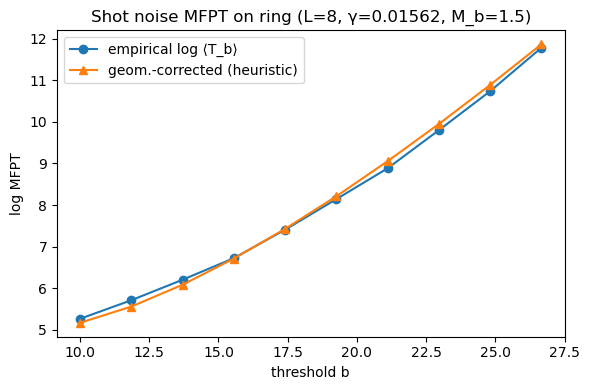

In [93]:
plt.figure(figsize=(6,4))
plt.plot(boverMb, logmfpt, marker="o", label="empirical log ⟨T_b⟩")
# plt.plot(df["b"], df["logT_arrhenius"], marker="s", label="Arrhenius only")
plt.plot(boverMb, ytest-1, marker="^", label="geom.-corrected (heuristic)")
plt.xlabel("threshold b")
plt.ylabel("log MFPT")
plt.title(f"Shot noise MFPT on ring (L={L}, γ={gamma:.4g}, M_b={M_b})")
plt.legend()
plt.tight_layout()
plt.show()

# Poisson arrivals

## Exponential marks

In [ ]:
import math
import numpy as np


def simulate_mfpt_exp(lam=1.0, gamma=0.5, lambda_b=1.0, b=6.0, trials=20000, seed=0):
    """
    Simulate the MFPT until first upcrossing of level b.
    Dynamics between arrivals: X -> X * exp(-gamma * Delta)
    At arrival: draw mark B ~ Exp(mean=lambda_b). If X^- + B >= b, stop.
                Else set X := X^- + B and continue.
    Returns a dict with mean, std, and all sample times.
    """
    rng = np.random.default_rng(seed)
    T_arr = np.empty(trials, dtype=float)

    for i in range(trials):
        X = 0.0
        t = 0.0
        while True:
            delta = rng.exponential(lam)
            X *= math.exp(-gamma * delta)  # decay to pre-jump value
            B = rng.exponential(lambda_b)  # jump (mark)
            t += delta
            if X + B >= b:
                # upcrossing happens at arrival (post-jump)
                break
            else:
                X += B  # update to post-jump and continue
        T_arr[i] = t

    return {
        "mean_T": float(np.mean(T_arr)),
        "std_T": float(np.std(T_arr, ddof=1)),
        "n": trials,
        "samples": T_arr,
    }


# -----------------------------
#  Theory: asymptotic MFPT and C2
# -----------------------------
def predicted_mfpt_exp(lam=1.0, gamma=0.5, lambda_b=1.0, b=6.0):
    """
    Return (predicted_MFPT, C2, mu, a) where:
        a  = lam / gamma
        mu = 2 / lam
        C2 = Gamma(1 + 2a) / Gamma(1 + a)^2
        predicted_MFPT = (mu / C2) * exp(b / lambda_b)
    """
    alpha=lam/gamma

    mu = 1.0 / lam
    a = lam / gamma

    pred_asym = (mu * alpha * sp.gamma(alpha)) * math.exp(b / lambda_b) * (lambda_b/b)**alpha
    return pred_asym, mu, a


# -----------------------------
#  Driver
# -----------------------------

# Parameters you can tweak
lam = 1.0        # Erlang-2 rate
gamma = 1.5     # relaxation
lambda_b = 1.0   # mean mark size
trials = 500   # Monte Carlo trials per b
seed = 42

# Thresholds to test (larger b -> closer to asymptotic)
b_values = np.arange(1,13,step=1.0)
mfpt_values = np.zeros(b_values.size)
pred_mfpt_values = np.zeros(b_values.size)

print(b_values,mfpt_values)

print("Erlang(k=2) interarrivals, exponential marks -- MFPT verification")
print(f"lam={lam}, gamma={gamma}, lambda_b={lambda_b}, trials={trials}\n")

# Theoretical Palm constant and predicted MFPT
for i,b in enumerate(b_values):
    sim = simulate_mfpt_exp(lam=lam, gamma=gamma, lambda_b=lambda_b,
                                b=b, trials=trials, seed=seed)
    pred, mu, a = predicted_mfpt_exp(lam=lam, gamma=gamma, lambda_b=lambda_b, b=b)
    mfpt_values[i] = sim["mean_T"]
    pred_mfpt_values[i] = pred
    ratio = sim["mean_T"] / pred
    se = sim["std_T"] / math.sqrt(sim["n"])
    print(f"b={b:>4.1f} |  Sim MFPT = {sim['mean_T']: .5f}  ± {se: .5f}   "
            f"Pred = {pred: .5f}  |  ratio sim/pred = {ratio: .3f}")

# # Cross-check C2 via Palm expectation (optional; can be slow if steps very large)
# est_C2 = estimate_palm_exp(lam=lam, gamma=gamma, lambda_b=lambda_b, steps=300_000, burn=2000, seed=123)
# a = lam / gamma
# C2 = math.gamma(1.0 + 2.0 * a) / (math.gamma(1.0 + a) ** 2)
# print("\nPalm expectation cross-check:")
# print(f"  Estimated E_Palm[e^(X^-/lambda_b)] ≈ {est_C2:.4f}")
# print(f"  Theoretical C2 = Γ(1+2a)/Γ(1+a)^2 with a={a:.3f}  =>  {C2:.4f}")


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Erlang(k=2) interarrivals, exponential marks -- MFPT verification
lam=1.0, gamma=1.5, lambda_b=1.0, trials=500

b= 1.0 |  Sim MFPT =  2.48217  ±  0.11252   Pred =  2.45392  |  ratio sim/pred =  1.012
b= 2.0 |  Sim MFPT =  5.30220  ±  0.21567   Pred =  4.20211  |  ratio sim/pred =  1.262
b= 3.0 |  Sim MFPT =  11.60204  ±  0.49461   Pred =  8.71702  |  ratio sim/pred =  1.331
b= 4.0 |  Sim MFPT =  24.92083  ±  1.15639   Pred =  19.56004  |  ratio sim/pred =  1.274
b= 5.0 |  Sim MFPT =  57.30969  ±  2.57575   Pred =  45.82027  |  ratio sim/pred =  1.251
b= 6.0 |  Sim MFPT =  127.68931  ±  5.57878   Pred =  110.29723  |  ratio sim/pred =  1.158
b= 7.0 |  Sim MFPT =  303.74500  ±  13.29504   Pred =  270.53777  |  ratio sim/pred =  1.123
b= 8.0 |  Sim MFPT =  772.54633  ±  33.19951   Pred =  672.76145  |  ratio sim/pred =  1.148
b= 9.0 |  Sim MFPT =  1791.63985  ±  75.05715   Pred =  1690.65073  |  ratio 

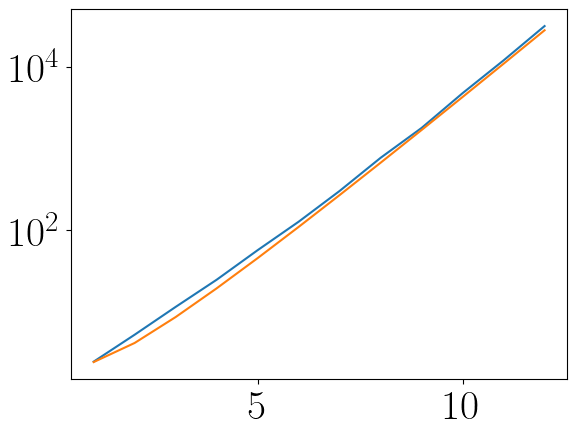

In [ ]:
plt.semilogy(b_values,mfpt_values)
plt.semilogy(b_values,pred_mfpt_values)

## Deterministic marks

In [1]:
import math
import numpy as np
import scipy.special as sp

def simulate_mfpt_exp(lam=1.0, gamma=0.5, b=6.0, trials=20000, seed=0):
    """
    Simulate the MFPT until first upcrossing of level b.
    Dynamics between arrivals: X -> X * exp(-gamma * Delta)
    At arrival: draw mark B ~ Exp(mean=lambda_b). If X^- + B >= b, stop.
                Else set X := X^- + B and continue.
    Returns a dict with mean, std, and all sample times.
    """
    rng = np.random.default_rng(seed)
    T_arr = np.empty(trials, dtype=float)
    

    for i in range(trials):
        if i ==0:
            t_impulses = []
        X = 0.0
        t = 0.0
        while True:
            delta = rng.exponential(lam)
            X *= math.exp(-gamma * delta)  # decay to pre-jump value
            B = 1
            t += delta
            if X + B >= b:
                if i==0:
                    t_impulses.append(t)
                # upcrossing happens at arrival (post-jump)
                break
            else:
                X += B  # update to post-jump and continue
                if i==0:
                    t_impulses.append(t)
        T_arr[i] = t
    
    return {
        "mean_T": float(np.mean(T_arr)),
        "std_T": float(np.std(T_arr, ddof=1)),
        "n": trials,
        "samples": T_arr,
        "t_impulses": t_impulses
    }


# -----------------------------
#  Theory: asymptotic MFPT and C2
# -----------------------------
def predicted_mfpt_exp(lam=1.0, gamma=0.5, b=6.0):
    """
    Return (predicted_MFPT, C2, mu, a) where:
        a  = lam / gamma
        mu = 2 / lam
        C2 = Gamma(1 + 2a) / Gamma(1 + a)^2
        predicted_MFPT = (mu / C2) * exp(b / lambda_b)
    """
    r = 1/lam
    pred_asym = sp.poch(r/gamma/2+1,b)*(r/gamma/2)**(-b)
    # pred_asym = sp.poch(r/gamma+1,2*b)*(r/gamma)**(-2*b)
    return pred_asym


# -----------------------------
#  Driver
# -----------------------------

# Parameters you can tweak
lam = 1.0        # Erlang-2 rate
gamma = 2     # relaxation
trials = 10000   # Monte Carlo trials per b
seed = 42

# Thresholds to test (larger b -> closer to asymptotic)
b_values = np.arange(1,5,step=0.5)
mfpt_values = np.zeros(b_values.size)
pred_mfpt_values = np.zeros(b_values.size)

print(b_values,mfpt_values)

print("Exp interarrivals, det marks -- MFPT verification")
print(f"lam={lam}, gamma={gamma}, trials={trials}\n")

for i,b in enumerate(b_values):
    sim = simulate_mfpt_exp(lam=lam, gamma=gamma,
                                b=b, trials=trials, seed=seed)
    pred= predicted_mfpt_exp(lam=lam, gamma=gamma, b=b)
    mfpt_values[i] = sim["mean_T"]
    pred_mfpt_values[i] = pred
    ratio = sim["mean_T"] / pred
    se = sim["std_T"] / math.sqrt(sim["n"])
    t_impulses = sim["t_impulses"]
    # plt.plot(t_impulses[-10::])
    # plt.show()
    print(f"b={b:>4.1f} |  Sim MFPT = {sim['mean_T']: .5f}  ± {se: .5f}   "
            f"Pred = {pred: .5f}  |  ratio sim/pred = {ratio: .3f}")


[1.  1.5 2.  2.5 3.  3.5 4.  4.5] [0. 0. 0. 0. 0. 0. 0. 0.]
Exp interarrivals, det marks -- MFPT verification
lam=1.0, gamma=2, trials=10000

b= 1.0 |  Sim MFPT =  0.98870  ±  0.00993   Pred =  5.00000  |  ratio sim/pred =  0.198
b= 1.5 |  Sim MFPT =  4.05848  ±  0.03920   Pred =  14.19554  |  ratio sim/pred =  0.286
b= 2.0 |  Sim MFPT =  10.50277  ±  0.10208   Pred =  45.00000  |  ratio sim/pred =  0.233
b= 2.5 |  Sim MFPT =  29.66457  ±  0.29900   Pred =  156.15097  |  ratio sim/pred =  0.190
b= 3.0 |  Sim MFPT =  105.20496  ±  1.02781   Pred =  585.00000  |  ratio sim/pred =  0.180
b= 3.5 |  Sim MFPT =  421.10813  ±  4.19346   Pred =  2342.26460  |  ratio sim/pred =  0.180
b= 4.0 |  Sim MFPT =  1948.93698  ±  19.64693   Pred =  9945.00000  |  ratio sim/pred =  0.196
b= 4.5 |  Sim MFPT =  9845.38586  ±  97.19652   Pred =  44503.02743  |  ratio sim/pred =  0.221


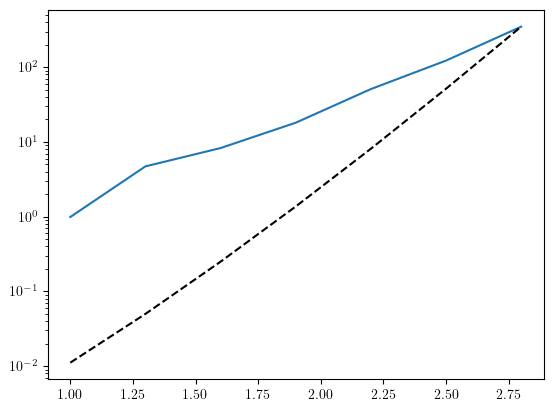

In [40]:
alpha = mfpt_values[-1]/pred_mfpt_values[-1]
plt.semilogy(b_values,mfpt_values)
plt.semilogy(b_values,pred_mfpt_values*alpha,'--k')

## Gamma impulses

In [53]:
import math
import numpy as np
import scipy.special as sp
import mpmath as mp

def simulate_mfpt_exp(lam=1.0, gamma=0.5, b=6.0, trials=20000, theta=1.0,k=2.0, seed=0):
    """
    Simulate the MFPT until first upcrossing of level b.
    Dynamics between arrivals: X -> X * exp(-gamma * Delta)
    At arrival: draw mark B ~ Exp(mean=lambda_b). If X^- + B >= b, stop.
                Else set X := X^- + B and continue.
    Returns a dict with mean, std, and all sample times.
    """
    rng = np.random.default_rng(seed)
    T_arr = np.empty(trials, dtype=float)
    
    for i in range(trials):
        X = 0.0
        t = 0.0
        while True:
            delta = rng.exponential(lam)
            X *= math.exp(-gamma * delta)  # decay to pre-jump value
            B = rng.gamma(k, theta)
            t += delta
            if X + B >= b:
                # upcrossing happens at arrival (post-jump)
                break
            else:
                X += B  # update to post-jump and continue
        T_arr[i] = t
    
    return {
        "mean_T": float(np.mean(T_arr)),
        "std_T": float(np.std(T_arr, ddof=1)),
        "n": trials,
        "samples": T_arr,
    }

def survival_gamma(u, k, theta):
    if u < 0:
        return 1.0
    return 1-mp.gammainc(k,a=0,b=u/theta,regularized=1)
# -----------------------------
#  Theory: asymptotic MFPT and C2
# -----------------------------
def predicted_mfpt_exp(lam=1.0, gamma=0.5, b=6.0,k=2,theta=1):
    import mpmath as mp
    mu1=theta 

    def I_n(b, n, k, theta, r, gamma_val):
        """Integral term for given n in the recursion formula."""
        # mu1=theta*(1+(k-1)*theta/b)
        f = lambda t: r*mp.e**(-r*t)*survival_gamma(b*gamma_val*t + mu1/n, k, theta)
        return mp.quad(f, [0, mp.inf])

    def step_ratio(b, k, theta, r, gamma_val, nmax=1, tol=1e-12):
        """Step ratio R(b) from heuristic recursion with sum up to nmax."""
        # mu1=theta*(1+(k-1)*theta/b)
        term1 = survival_gamma(b+mu1, k, theta)/survival_gamma(b, k, theta)
        s = mp.mpf('0')
        for n in range(1, nmax+1):
            val = I_n(b, n, k, theta, r, gamma_val)
            if abs(val) < tol:
                break
            s += val**n
        return term1 + s

    def MFPT(b, k, theta, r, gamma_val, nmax=1):
        """Compute <T_b> via product formula using recursion."""
        # nmax = 1 works for k<1 (single impulse dominates)
        mmax = int(b/mu1)
        prod = mp.mpf('1')
        for m in range(1, mmax+1):
            Rm = step_ratio(m*mu1, k, theta, r, gamma_val, nmax=nmax)
            prod *= 1.0/Rm
        return prod / r

    # Example usage
    Tb_est = MFPT(b=b, k=k, theta=theta, r=1/lam, gamma_val=gamma, nmax=1)
    return Tb_est




# Parameters you can tweak
lam = 1.0        # exp rate
theta=1.0 # scale
k=1.3 # shape
gamma = 2     # relaxation
trials = 500   # Monte Carlo trials per b
seed = 42

# Thresholds to test (larger b -> closer to asymptotic)
b_values = np.arange(4,14,step=1)
mfpt_values = np.zeros(b_values.size)
pred_mfpt_values = np.zeros(b_values.size)

# print(b_values,mfpt_values)

print("Exp interarrivals, erlang marks -- MFPT verification")
print(f"lam={lam}, gamma={gamma}, trials={trials}\n")

for i,b in enumerate(b_values):
    sim = simulate_mfpt_exp(lam=lam, gamma=gamma,
                                b=b, trials=trials, seed=seed,theta=theta,k=k)
    pred= predicted_mfpt_exp(lam=lam, gamma=gamma, b=b,k=k,theta=theta)
    mfpt_values[i] = sim["mean_T"]
    pred_mfpt_values[i] = pred
    ratio = sim["mean_T"] / pred
    se = sim["std_T"] / math.sqrt(sim["n"])
    print(b)



Exp interarrivals, erlang marks -- MFPT verification
lam=1.0, gamma=2, trials=500

4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

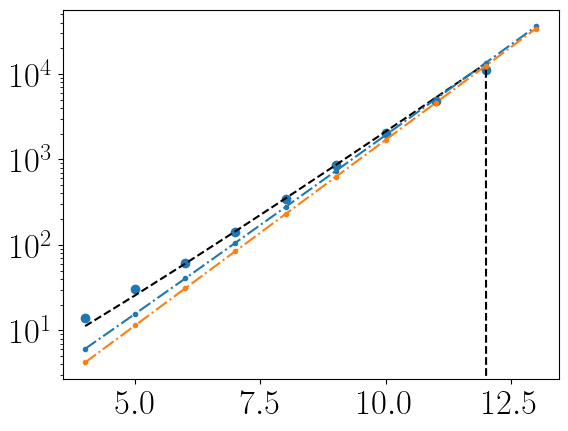

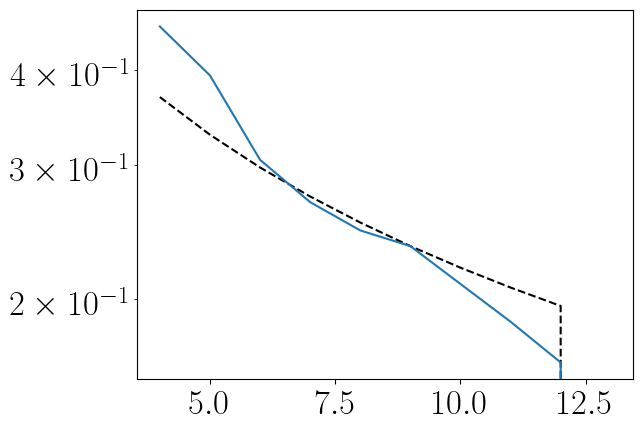

In [55]:
### FOR ERLANG MARKS k=1.3 AND mu1=theta 
def survival_gamma_sp(u, k, theta):
    return sp.gammaincc(k,u/theta)


alpha = mfpt_values[-5]/pred_mfpt_values[-5]
plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,alpha*pred_mfpt_values,'--k')
plt.semilogy(b_values, 1/survival_gamma_sp(b_values,k,theta*1)/5, '.-.')
plt.semilogy(b_values, np.exp(b_values)/13, '.-.')
plt.show()
plt.semilogy(b_values,alpha*pred_mfpt_values*survival_gamma_sp(b_values,k,theta),'--k')
plt.semilogy(b_values,mfpt_values*survival_gamma_sp(b_values,k,theta),'-')
plt.show()

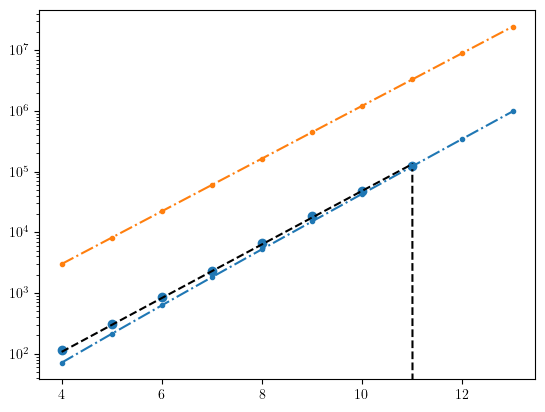

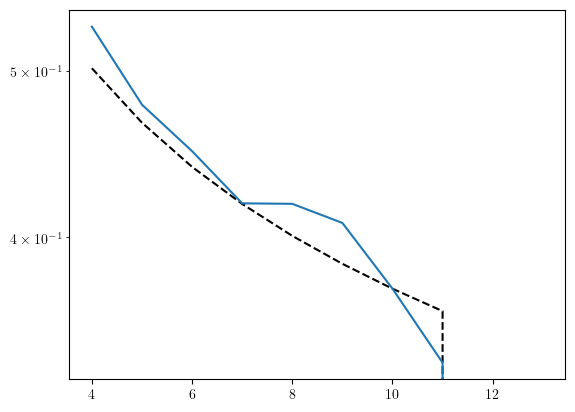

In [302]:
### FOR ERLANG MARKS k=0.5 WITH CHOOSING MU=THETA
def survival_gamma_sp(u, k, theta):
    return sp.gammaincc(k,u/theta)


alpha = mfpt_values[-4]/pred_mfpt_values[-4]
plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,alpha*pred_mfpt_values,'--k')
plt.semilogy(b_values, 1/survival_gamma_sp(b_values,k,theta*1)/3, '.-.')
plt.semilogy(b_values, np.exp(b_values)*55, '.-.')
plt.show()
plt.semilogy(b_values,alpha*pred_mfpt_values*survival_gamma_sp(b_values,k,theta),'--k')
plt.semilogy(b_values,mfpt_values*survival_gamma_sp(b_values,k,theta),'-')
plt.show()

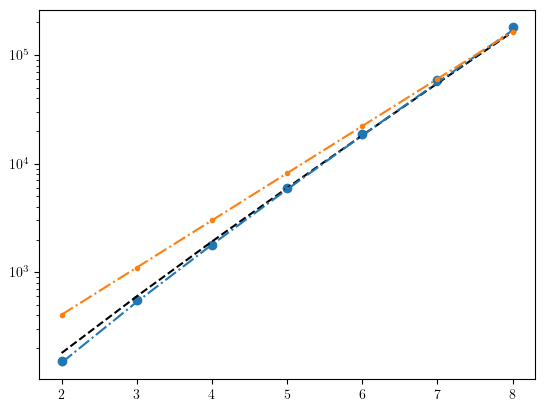

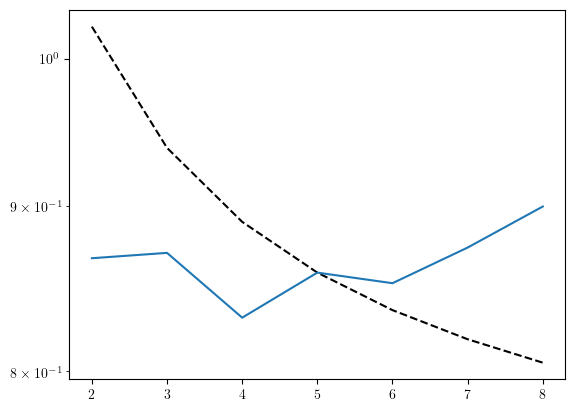

In [296]:
### FOR ERLANG MARKS k=0.1 WITH CHOOSING MU=THETA
def survival_gamma_sp(u, k, theta):
    return sp.gammaincc(k,u/theta)


alpha = mfpt_values[-4]/pred_mfpt_values[-4]
plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,alpha*pred_mfpt_values,'--k')
plt.semilogy(b_values, 1/survival_gamma_sp(b_values,k,theta*1)/1.2, '.-.')
plt.semilogy(b_values, np.exp(b_values)*55, '.-.')
plt.show()
plt.semilogy(b_values,alpha*pred_mfpt_values*survival_gamma_sp(b_values,k,theta),'--k')
plt.semilogy(b_values,mfpt_values*survival_gamma_sp(b_values,k,theta),'-')
plt.show()

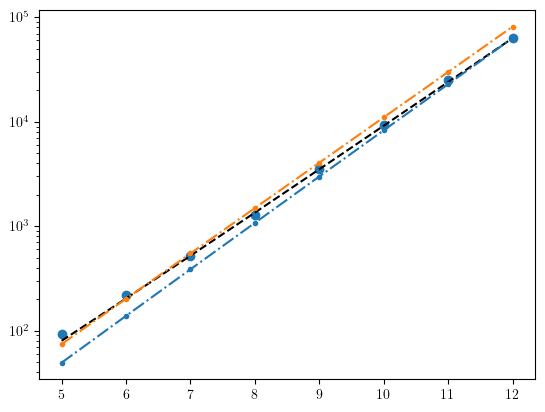

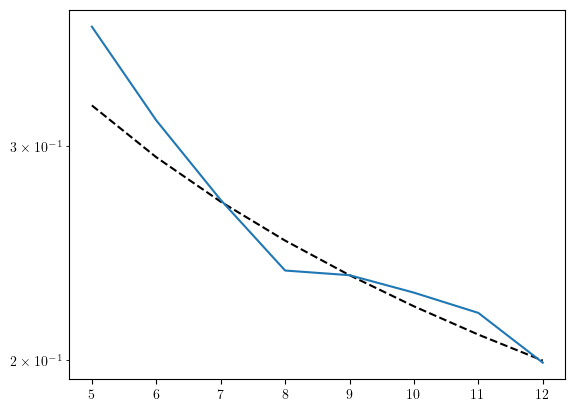

In [285]:
### FOR ERLANG MARKS k=0.8 WITH CHOOSING MU=THETA
def survival_gamma_sp(u, k, theta):
    return sp.gammaincc(k,u/theta)


alpha = mfpt_values[-4]/pred_mfpt_values[-4]
plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,alpha*pred_mfpt_values,'--k')
plt.semilogy(b_values, 1/survival_gamma_sp(b_values,k,theta*1)/5, '.-.')
plt.semilogy(b_values, np.exp(b_values)/2, '.-.')
plt.show()
plt.semilogy(b_values,alpha*pred_mfpt_values*survival_gamma_sp(b_values,k,theta),'--k')
plt.semilogy(b_values,mfpt_values*survival_gamma_sp(b_values,k,theta),'-')
plt.show()

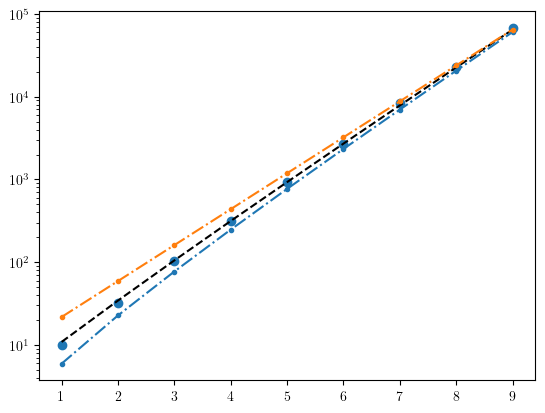

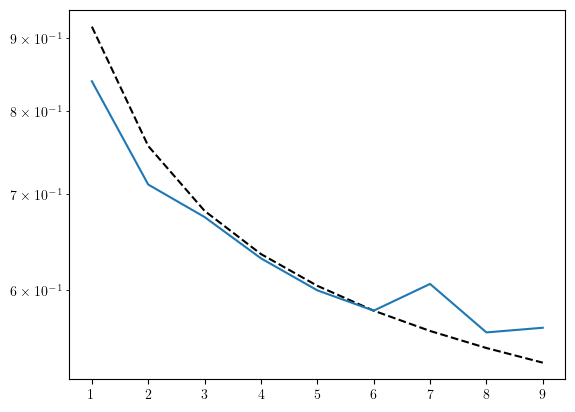

In [ ]:
### FOR ERLANG MARKS k=0.3 CHOOSING MU=THETA
def survival_gamma_sp(u, k, theta):
    return sp.gammaincc(k,u/theta)


alpha = mfpt_values[-4]/pred_mfpt_values[-4]
plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,alpha*pred_mfpt_values,'--k')
plt.semilogy(b_values, 1/survival_gamma_sp(b_values,k,theta*1)/2, '.-.')
plt.semilogy(b_values, np.exp(b_values)*8, '.-.')
plt.show()
plt.semilogy(b_values,alpha*pred_mfpt_values*survival_gamma_sp(b_values,k,theta),'--k')
plt.semilogy(b_values,mfpt_values*survival_gamma_sp(b_values,k,theta),'-')
plt.show()

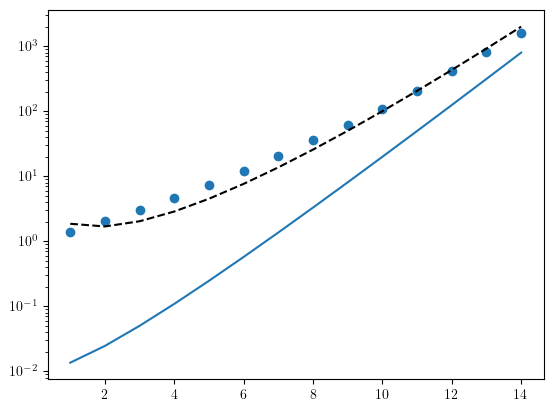

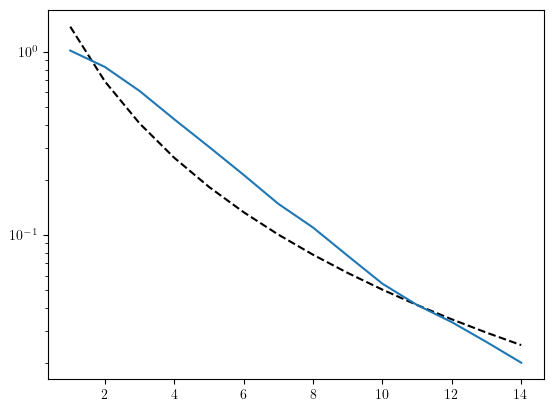

In [251]:
### FOR ERLANG MARKS
def survival_gamma_sp(u, k, theta):
    return sp.gammaincc(k,u/theta)


alpha = mfpt_values[-4]/pred_mfpt_values[-4]
plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,alpha*pred_mfpt_values,'--k')
plt.semilogy(b_values, 1/survival_gamma_sp(b_values,k,theta*1)/100)
plt.show()
plt.semilogy(b_values,alpha*pred_mfpt_values*survival_gamma_sp(b_values,k,theta),'--k')
plt.semilogy(b_values,mfpt_values*survival_gamma_sp(b_values,k,theta),'-')
plt.show()

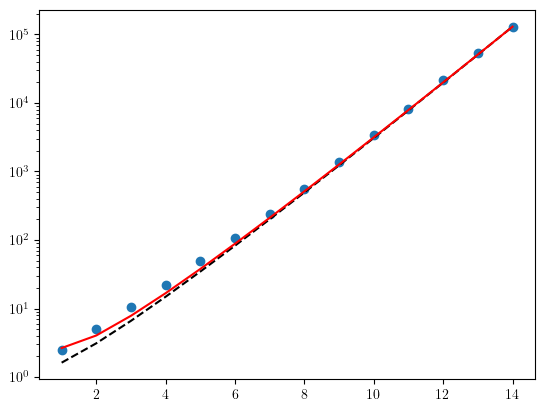

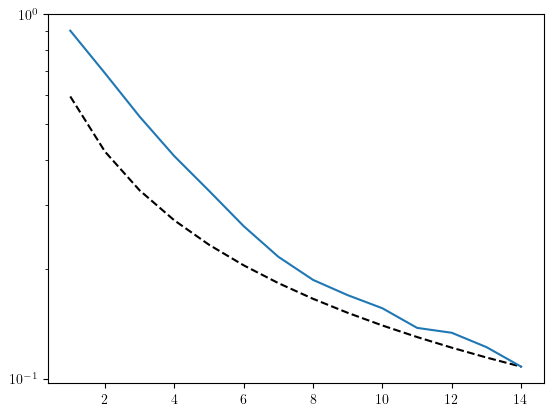

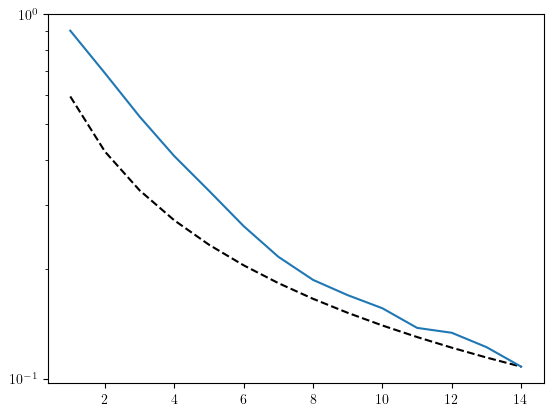

In [238]:
### REFERENCE : FOR EXP MARKS
def survival_gamma_sp(u, k, theta):
    return sp.gammaincc(k,u/theta)

alpha = mfpt_values[-1]/pred_mfpt_values[-1]
pred_analytical = np.exp(b_values/theta)*(b_values/theta)**(-1/lam/gamma)
beta = mfpt_values[-1]/pred_analytical[-1]

plt.scatter(b_values,mfpt_values)
plt.semilogy(b_values,alpha*pred_mfpt_values,'--k')
plt.semilogy(b_values, beta*pred_analytical,color='red' )
plt.show()
plt.semilogy(b_values,alpha*pred_mfpt_values*survival_gamma_sp(b_values,k,theta),'--k')
plt.semilogy(b_values,mfpt_values*survival_gamma_sp(b_values,k,theta),'-')
plt.show()
plt.semilogy(b_values,alpha*pred_mfpt_values/np.exp(b_values/theta),'--k')
plt.semilogy(b_values,mfpt_values/np.exp(b_values/theta),'-')
plt.show()

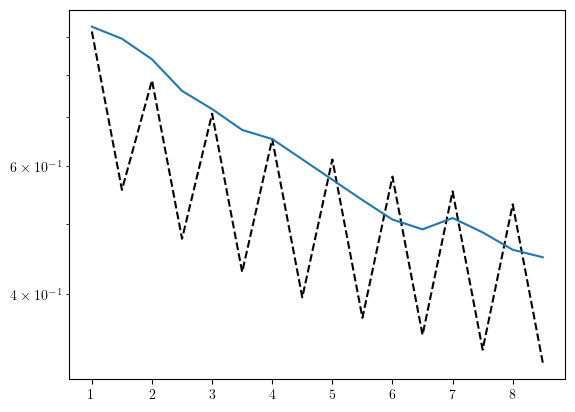

In [185]:
plt.semilogy(b_values,alpha*pred_mfpt_values/np.exp(b_values/theta),'--k')
plt.semilogy(b_values,mfpt_values/np.exp(b_values/theta),'-')

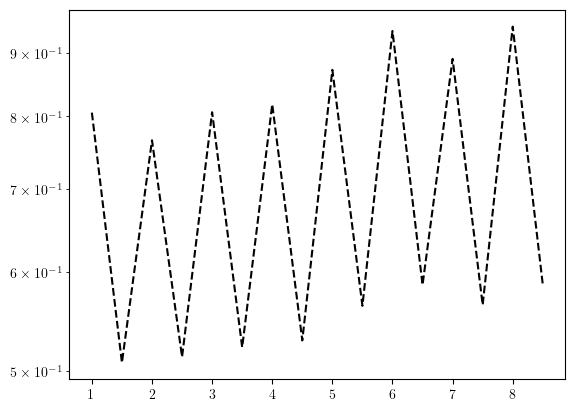

In [187]:
plt.semilogy(b_values,pred_mfpt_values/mfpt_values,'--k')
